2024-3-9

In [ ]:
import requests
import bs4
from bs4 import BeautifulSoup
from IPython.display import display
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, timezone
import re
import json
from typing import List, Dict, Tuple, Optional, Union, Any, Set
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

# Get data from the HTML source code of a webpage using Beautiful Soup

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

## Example: famous quotes

Get the famous quotes data from this website: http://quotes.toscrape.com

Goal: parse the quotes in a nicely structural format so that they can be easily queried and analyzed later. Also save the cleaned data to disk.

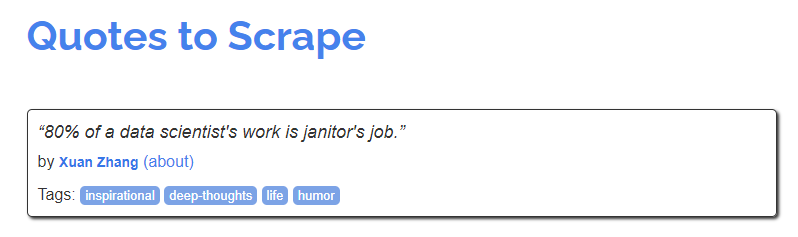

In [ ]:
url = "http://quotes.toscrape.com"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Quotes to Scrape</title>
<link href="/static/bootstrap.min.css" rel="stylesheet"/>
<link href="/static/main.css" rel="stylesheet"/>
</head>
<body>
<div class="container">
<div class="row header-box">
<div class="col-md-8">
<h1>
<a href="/" style="text-decoration: none">Quotes to Scrape</a>
</h1>
</div>
<div class="col-md-4">
<p>
<a href="/login">Login</a>
</p>
</div>
</div>
<div class="row">
<div class="col-md-8">
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="

### Explore data

The quote data are under the `div` elements with the `quote` class name, so we need to get it from the HTML document

In [ ]:
quote_divs = soup.find_all('div', {'class': 'quote'})
quote_divs

[<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
 <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
 <span>by <small class="author" itemprop="author">Albert Einstein</small>
 <a href="/author/Albert-Einstein">(about)</a>
 </span>
 <div class="tags">
             Tags:
             <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
 <a class="tag" href="/tag/change/page/1/">change</a>
 <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
 <a class="tag" href="/tag/thinking/page/1/">thinking</a>
 <a class="tag" href="/tag/world/page/1/">world</a>
 </div>
 </div>,
 <div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
 <span class="text" itemprop="text">“It is our choices, Harry, that show what we truly are, far more than our abilities.”</span>
 <span>by <small class="author" itempr

In [ ]:
len(quote_divs)

10

In [ ]:
quote_div = quote_divs[0]
quote_div

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

In [ ]:
quote_text = quote_div.findChild('span', {'class': 'text'})
quote_text

<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>

In [ ]:
quote_text_str = quote_text.text
quote_text_str

'“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'

In [ ]:
quote_author = quote_div.findChild('small', {'class': 'author'})
quote_author

<small class="author" itemprop="author">Albert Einstein</small>

In [ ]:
quote_author_str = quote_author.text
quote_author_str

'Albert Einstein'

In [ ]:
quote_tags = quote_div.findChildren('a', {'class': 'tag'})
quote_tags

[<a class="tag" href="/tag/change/page/1/">change</a>,
 <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>,
 <a class="tag" href="/tag/thinking/page/1/">thinking</a>,
 <a class="tag" href="/tag/world/page/1/">world</a>]

In [ ]:
quote_tags_list = [tag.text for tag in quote_tags]
quote_tags_list

['change', 'deep-thoughts', 'thinking', 'world']

In [ ]:
type(quote_div)

bs4.element.Tag

In [ ]:
def get_quote_data_from_one_element(quote_div: bs4.element.Tag) -> Tuple[str, str, List[str]]:
  '''Parse data from a single quote div element and return the fields we need

  Args:
    quote_div: quote div element (bs4 object)

  Returns:
    quote text string
    quote author
    quote tags as a list of strings
  '''
  # get text
  quote_text = quote_div.findChild('span', {'class': 'text'})
  quote_text_str = quote_text.text

  # get author
  quote_author = quote_div.findChild('small', {'class': 'author'})
  quote_author_str = quote_author.text

  # get tags
  quote_tags = quote_div.findChildren('a', {'class': 'tag'})
  quote_tags_list = [tag.text for tag in quote_tags]

  return quote_text_str, quote_author_str, quote_tags_list


get_quote_data_from_one_element(quote_divs[3])

('“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
 'Jane Austen',
 ['aliteracy', 'books', 'classic', 'humor'])

### Collect data for one page

In [ ]:
page_data_list: List[Dict[str, Any]] = []

for quote_div in quote_divs:
  quote_text_str, quote_author_str, quote_tags_list = get_quote_data_from_one_element(quote_div)
  quote_dict = {
      'quote_text_str': quote_text_str,
      'quote_author_str':quote_author_str,
      'quote_tags_list': ", ".join(quote_tags_list),
  }
  page_data_list.append(quote_dict)

page_data_list

[{'quote_text_str': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'quote_author_str': 'Albert Einstein',
  'quote_tags_list': 'change, deep-thoughts, thinking, world'},
 {'quote_text_str': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'quote_author_str': 'J.K. Rowling',
  'quote_tags_list': 'abilities, choices'},
 {'quote_text_str': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”',
  'quote_author_str': 'Albert Einstein',
  'quote_tags_list': 'inspirational, life, live, miracle, miracles'},
 {'quote_text_str': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
  'quote_author_str': 'Jane Austen',
  'quote_tags_list': 'aliteracy, books, classic, humor'},
 {'quote_text_str': "“Imperfection is beauty, madness is genius and it's bet

In [ ]:
df_page = pd.DataFrame(page_data_list)
df_page

,quote_text_str,quote_author_str,quote_tags_list
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"
5,“Try not to become a man of success. Rather be...,Albert Einstein,"adulthood, success, value"
6,“It is better to be hated for what you are tha...,André Gide,"life, love"
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,"edison, failure, inspirational, paraphrased"
8,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt,misattributed-eleanor-roosevelt
9,"“A day without sunshine is like, you know, nig...",Steve Martin,"humor, obvious, simile"


In [ ]:
def collect_quote_data_from_one_page(url: str) -> pd.DataFrame:
  '''Retrive info from the url and parse quote data into a dataframe

  Args:
    url: page link

  Returns:
    dataframe containing the structured data for the page
  '''
  # retrieve HTML data
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'} #use this to make the website think we are not a bot
  page = requests.get(url, headers=headers)
  soup = BeautifulSoup(page.content, 'html.parser')

  # parse quote data as a list of dict
  quote_divs = soup.find_all('div',  {'class': 'quote'})
  page_data_list: List[Dict[str, Any]] = []

  for quote_div in quote_divs:
    quote_text_str, quote_author_str, quote_tags_list = get_quote_data_from_one_element(quote_div)
    quote_dict = {
        'text': quote_text_str,
        'author':quote_author_str,
        'tags': ", ".join(quote_tags_list),
    }
    page_data_list.append(quote_dict)

  # convert quote data to dataframe
  df_page = pd.DataFrame(page_data_list)
  return df_page


collect_quote_data_from_one_page('https://quotes.toscrape.com/page/2/')

,text,author,tags
0,“This life is what you make it. No matter what...,Marilyn Monroe,"friends, heartbreak, inspirational, life, love..."
1,“It takes a great deal of bravery to stand up ...,J.K. Rowling,"courage, friends"
2,"“If you can't explain it to a six year old, yo...",Albert Einstein,"simplicity, understand"
3,"“You may not be her first, her last, or her on...",Bob Marley,love
4,"“I like nonsense, it wakes up the brain cells....",Dr. Seuss,fantasy
5,"“I may not have gone where I intended to go, b...",Douglas Adams,"life, navigation"
6,"“The opposite of love is not hate, it's indiff...",Elie Wiesel,"activism, apathy, hate, indifference, inspirat..."
7,"“It is not a lack of love, but a lack of frien...",Friedrich Nietzsche,"friendship, lack-of-friendship, lack-of-love, ..."
8,"“Good friends, good books, and a sleepy consci...",Mark Twain,"books, contentment, friends, friendship, life"
9,“Life is what happens to us while we are makin...,Allen Saunders,"fate, life, misattributed-john-lennon, plannin..."


### Scrape data from all pages

Now that we know how to convert the data from one page to a dataframe, we can make an automated process to scrape every page and combine all the information in a single dataframe.

In [ ]:
n_pages = 10 #total pages on the website
df_list: List[pd.DataFrame] = [] #use this to store individual tables for different pages (we'll glue them together in the end)

for page_id in tqdm(range(1,n_pages+1)):
  page_url = f'https://quotes.toscrape.com/page/{page_id}/'
  df_page = collect_quote_data_from_one_page(page_url)
  df_list += [df_page]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
df_combined = pd.concat(df_list, axis=0).reset_index(drop=True)
df_combined

,text,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"
...,...,...,...
95,“You never really understand a person until yo...,Harper Lee,better-life-empathy
96,“You have to write the book that wants to be w...,Madeleine L'Engle,"books, children, difficult, grown-ups, write, ..."
97,“Never tell the truth to people who are not wo...,Mark Twain,truth
98,"“A person's a person, no matter how small.”",Dr. Seuss,inspirational


In [ ]:
%%time
date = datetime.now().date()
df_combined.to_csv(f"Famous quotes scraped data {date}.csv", encoding="utf-8-sig")

CPU times: user 5.38 ms, sys: 995 µs, total: 6.38 ms
Wall time: 7.66 ms


In [ ]:
!ls -l *.csv

-rw-r--r-- 1 root root 16939 Mar 10 15:45 'Famous quotes scraped data 2024-03-10.csv'


### Using the scraped data

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
 1   author  100 non-null    object
 2   tags    100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [ ]:
df_combined['tags']

0                change, deep-thoughts, thinking, world
1                                    abilities, choices
2          inspirational, life, live, miracle, miracles
3                      aliteracy, books, classic, humor
4                            be-yourself, inspirational
                            ...                        
95                                  better-life-empathy
96    books, children, difficult, grown-ups, write, ...
97                                                truth
98                                        inspirational
99                                          books, mind
Name: tags, Length: 100, dtype: object

In [ ]:
df_humor = df_combined[df_combined['tags'].str.contains('humor')]
df_humor

,text,author,tags
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
9,"“A day without sunshine is like, you know, nig...",Steve Martin,"humor, obvious, simile"
23,“Anyone who thinks sitting in church can make ...,Garrison Keillor,"humor, religion"
24,“Beauty is in the eye of the beholder and it m...,Jim Henson,humor
35,“All you need is love. But a little chocolate ...,Charles M. Schulz,"chocolate, food, humor"
62,"“Remember, we're madly in love, so it's all ri...",Suzanne Collins,humor
71,“Some people never go crazy. What truly horrib...,Charles Bukowski,humor
72,"“The trouble with having an open mind, of cour...",Terry Pratchett,"humor, open-mind, thinking"
73,“Think left and think right and think low and ...,Dr. Seuss,"humor, philosophy"
75,“The reason I talk to myself is because I’m th...,George Carlin,"humor, insanity, lies, lying, self-indulgence,..."


In [ ]:
for i, row in df_humor.iterrows():
  print(row['text'], f"--{row['author']}")

“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.” --Jane Austen
“A day without sunshine is like, you know, night.” --Steve Martin
“Anyone who thinks sitting in church can make you a Christian must also think that sitting in a garage can make you a car.” --Garrison Keillor
“Beauty is in the eye of the beholder and it may be necessary from time to time to give a stupid or misinformed beholder a black eye.” --Jim Henson
“All you need is love. But a little chocolate now and then doesn't hurt.” --Charles M. Schulz
“Remember, we're madly in love, so it's all right to kiss me anytime you feel like it.” --Suzanne Collins
“Some people never go crazy. What truly horrible lives they must lead.” --Charles Bukowski
“The trouble with having an open mind, of course, is that people will insist on coming along and trying to put things in it.” --Terry Pratchett
“Think left and think right and think low and think high. Oh, the thinks you can think up

### (OPTIONAL) Webscraping with multi-threading

In [ ]:
n_pages = 10 #total pages on the website
df_list = [] #use this to store individual tables for different pages (we'll glue them together in the end)

max_workers = 64
with ThreadPoolExecutor(max_workers=max_workers) as executor:
  futures = []
  for page_id in tqdm(range(1,n_pages+1), desc="Submitting jobs"):
    page_url = f'https://quotes.toscrape.com/page/{page_id}/'
    futures.append(executor.submit(
        collect_quote_data_from_one_page,
        url=url,
    ))

  for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting results"):
    df_page = future.result()
    df_list += [df_page]

df_combined = pd.concat(df_list, axis=0).reset_index(drop=True)
df_combined

Submitting jobs:   0%|          | 0/10 [00:00<?, ?it/s]

,text,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"
...,...,...,...
95,“Try not to become a man of success. Rather be...,Albert Einstein,"adulthood, success, value"
96,“It is better to be hated for what you are tha...,André Gide,"life, love"
97,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,"edison, failure, inspirational, paraphrased"
98,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt,misattributed-eleanor-roosevelt


## Example: books

Get the books data from this website: https://books.toscrape.com/

Goal: scrape the book data (such as title, price, description, and rating) in a nicely structural format so that they can be easily queried and analyzed later. Also download the book cover images.

In [ ]:
# url = 'http://books.toscrape.com'
url = 'https://books.toscrape.com/catalogue/page-1.html'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
soup


<!DOCTYPE html>

<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->
<head>
<title>
    All products | Books to Scrape - Sandbox
</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="24th Jun 2016 09:30" name="created"/>
<meta content="" name="description"/>
<meta content="width=device-width" name="viewport"/>
<meta content="NOARCHIVE,NOCACHE" name="robots"/>
<!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
<!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
<link href="../static/oscar/favicon.ico" rel="shortcut icon"/>
<link href="../static/oscar/css/styles.css" rel="stylesheet" type="text/css"/>
<link 

### Explore  data

In [ ]:
all_urls = soup.find_all('a')
all_urls

[<a href="../index.html">Books to Scrape</a>,
 <a href="../index.html">Home</a>,
 <a href="category/books_1/index.html">
                             
                                 Books
                             
                         </a>,
 <a href="category/books/travel_2/index.html">
                             
                                 Travel
                             
                         </a>,
 <a href="category/books/mystery_3/index.html">
                             
                                 Mystery
                             
                         </a>,
 <a href="category/books/historical-fiction_4/index.html">
                             
                                 Historical Fiction
                             
                         </a>,
 <a href="category/books/sequential-art_5/index.html">
                             
                                 Sequential Art
                             
                         <

### Find all book subpage links

regular expression (regex) reference: https://regex101.com/

In [ ]:
for s in set(url['href'] for url in all_urls):
  print(s)

category/books/science-fiction_16/index.html
category/books/fantasy_19/index.html
category/books/autobiography_27/index.html
category/books/self-help_41/index.html
category/books/add-a-comment_18/index.html
category/books/academic_40/index.html
soumission_998/index.html
sharp-objects_997/index.html
category/books/science_22/index.html
the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html
category/books/music_14/index.html
category/books/young-adult_21/index.html
scott-pilgrims-precious-little-life-scott-pilgrim-1_987/index.html
category/books/philosophy_7/index.html
category/books/childrens_11/index.html
the-black-maria_991/index.html
category/books/nonfiction_13/index.html
category/books/poetry_23/index.html
category/books/thriller_37/index.html
the-dirty-little-secrets-of-getting-your-dream-job_994/index.html
shakespeares-sonnets_989/index.html
category/books/default_15/index.html
category/books/mystery_3/index.html
category/books/histor

In [ ]:
book_urls = set(url['href'] for url in all_urls if re.search(r"^[^\/]+_\d+/index\.html", url.get('href')))
book_urls

{'a-light-in-the-attic_1000/index.html',
 'its-only-the-himalayas_981/index.html',
 'libertarianism-for-beginners_982/index.html',
 'mesaerion-the-best-science-fiction-stories-1800-1849_983/index.html',
 'olio_984/index.html',
 'our-band-could-be-your-life-scenes-from-the-american-indie-underground-1981-1991_985/index.html',
 'rip-it-up-and-start-again_986/index.html',
 'sapiens-a-brief-history-of-humankind_996/index.html',
 'scott-pilgrims-precious-little-life-scott-pilgrim-1_987/index.html',
 'set-me-free_988/index.html',
 'shakespeares-sonnets_989/index.html',
 'sharp-objects_997/index.html',
 'soumission_998/index.html',
 'starving-hearts-triangular-trade-trilogy-1_990/index.html',
 'the-black-maria_991/index.html',
 'the-boys-in-the-boat-nine-americans-and-their-epic-quest-for-gold-at-the-1936-berlin-olympics_992/index.html',
 'the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html',
 'the-dirty-little-secrets-of-getting-your-dream-job

In [ ]:
def get_book_urls_on_page(page_url: str) -> Set[str]:
  page = requests.get(page_url)
  soup = BeautifulSoup(page.content, 'html.parser')
  all_urls = soup.find_all('a')
  book_urls = set(url['href'] for url in all_urls if re.search(r"^[^\/]+_\d+/index\.html", url.get('href')))
  return book_urls


get_book_urls_on_page('https://books.toscrape.com/catalogue/page-50.html')

{'1000-places-to-see-before-you-die_1/index.html',
 '1st-to-die-womens-murder-club-1_2/index.html',
 'a-spys-devotion-the-regency-spies-of-london-1_3/index.html',
 'ajin-demi-human-volume-1-ajin-demi-human-1_4/index.html',
 'alice-in-wonderland-alices-adventures-in-wonderland-1_5/index.html',
 'beyond-good-and-evil_6/index.html',
 'bleach-vol-1-strawberry-and-the-soul-reapers-bleach-1_7/index.html',
 'blood-defense-samantha-brinkman-1_8/index.html',
 'bounty-colorado-mountain-7_9/index.html',
 'bridget-joness-diary-bridget-jones-1_10/index.html',
 'bright-lines_11/index.html',
 'charitys-cross-charles-towne-belles-4_12/index.html',
 'charlie-and-the-chocolate-factory-charlie-bucket-1_13/index.html',
 'choosing-our-religion-the-spiritual-lives-of-americas-nones_14/index.html',
 'deep-under-walker-security-1_15/index.html',
 'eat-pray-love_16/index.html',
 'emma_17/index.html',
 'fighting-fate-fighting-6_18/index.html',
 'forever-rockers-the-rocker-12_19/index.html',
 'frankenstein_20/in

In [ ]:
n_pages = 50
all_book_urls = []

max_workers = 64
with ThreadPoolExecutor(max_workers=max_workers) as executor:
  futures = []
  for page_id in tqdm(range(1,n_pages+1), desc="Submitting jobs"):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'} #use this to make the website think we are not a bot
    page_url = f'https://books.toscrape.com/catalogue/page-{page_id}.html'
    futures.append(executor.submit(
        get_book_urls_on_page,
        page_url=page_url,
    ))

  for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting results"):
    book_urls: Set[str] = future.result()
    all_book_urls += list(book_urls)

all_book_urls = [f'https://books.toscrape.com/catalogue/{s}' for s in all_book_urls]
len(all_book_urls)

Submitting jobs:   0%|          | 0/50 [00:00<?, ?it/s]

1000

In [ ]:
all_book_urls

['https://books.toscrape.com/catalogue/the-devil-wears-prada-the-devil-wears-prada-1_243/index.html',
 'https://books.toscrape.com/catalogue/the-guns-of-august_254/index.html',
 'https://books.toscrape.com/catalogue/the-hitchhikers-guide-to-the-galaxy-hitchhikers-guide-to-the-galaxy-1_255/index.html',
 'https://books.toscrape.com/catalogue/the-demon-haunted-world-science-as-a-candle-in-the-dark_242/index.html',
 'https://books.toscrape.com/catalogue/the-goldfinch_252/index.html',
 'https://books.toscrape.com/catalogue/the-elegant-universe-superstrings-hidden-dimensions-and-the-quest-for-the-ultimate-theory_245/index.html',
 'https://books.toscrape.com/catalogue/the-infinities_257/index.html',
 'https://books.toscrape.com/catalogue/the-husbands-secret_256/index.html',
 'https://books.toscrape.com/catalogue/the-giver-the-giver-quartet-1_251/index.html',
 'https://books.toscrape.com/catalogue/the-end-of-faith-religion-terror-and-the-future-of-reason_246/index.html',
 'https://books.toscra

### Exercise: finish the rest webscraping job (because I'm too lazy to do it) 😏

**Acceptance criteria:**

1. Make a Python webscraper that can go into each book subpage link above, and retrieve the book data in parallel (using multi-threading)

2. For each book, retrieve title (str), price (float), stock availability (int), description (str), star rating (int), and cover image URL (str)

3. Store all retrieved book information as structred data in a dataframe. Save the dataframe to disk as csv. The dataframe should contain 1000 rows for 1000 books.

4. Make another Python function that can load the saved book data csv, and download all the book cover images programmatically into a target folder (also with multi-threading).

Search online and resolve any technical difficulties independently to earn bragging rights. 💪

In [ ]:
# Your code here

In [ ]:
# Your code here

In [ ]:
# Your code here

In [ ]:
# Your code here

# Get data using the API (Application Programming Interface) provided by a website server or database

### Example: JSON API request

Retrieve toy data from this website via their API: https://jsonplaceholder.typicode.com/

In [ ]:
class APIRetriever:
  """
  A class for retrieving data from a sample API (JSONPlaceholder).

  Args:
    base_url (str, optional): Base URL of the API. Defaults to 'https://jsonplaceholder.typicode.com'.
    verbose (bool, optional): If True, print additional information during retrieval. Defaults to False.
  """
  def __init__(
    self,
    base_url: str = 'https://jsonplaceholder.typicode.com',
    verbose: bool = False,
  ) -> None:
    """
    Initializes an instance of the APIRetriever class.

    Parameters:
      base_url (str, optional): Base URL of the API. Defaults to 'https://jsonplaceholder.typicode.com'.
      verbose (bool, optional): If True, print additional information during retrieval. Defaults to False.
    """
    self.base_url = base_url
    self.verbose = verbose

  def get_user_data(self, user_id: int) -> Optional[Dict[str, Any]]:
    """
    Retrieve user data for a specified user ID.

    Parameters:
      user_id (int): The ID of the user.

    Returns:
      Optional[Dict[str, Any]]: A dictionary containing user data if successful, otherwise None.
    """
    url = f"{self.base_url}/users/{user_id}"
    response = requests.get(url)

    if response.status_code == 200:
      return response.json()
    else:
      if self.verbose:
        print(f"Failed to retrieve user data. Status code: {response.status_code}")
      return None

  def get_posts_by_user(self, user_id: int) -> Optional[List[Dict[str, Any]]]:
    """
    Retrieve posts for a specified user ID.

    Parameters:
      user_id (int): The ID of the user.

    Returns:
      Optional[List[Dict[str, Any]]]: A list of dictionaries containing posts data if successful, otherwise None.
    """
    url = f"{self.base_url}/posts?userId={user_id}"
    response = requests.get(url)

    if response.status_code == 200:
      return response.json()
    else:
      if self.verbose:
        print(f"Failed to retrieve posts. Status code: {response.status_code}")
      return None


# Instantiate the APIRetriever class
api_retriever = APIRetriever()

# Retrieve user data for user with ID 1
user_data = api_retriever.get_user_data(1)
if user_data:
  print(f"User Data:\n{user_data}\n")

# Retrieve posts for user with ID 1
posts_data = api_retriever.get_posts_by_user(1)
if posts_data:
  print(f"Posts Data:\n{posts_data}\n")


User Data:
{'id': 1, 'name': 'Leanne Graham', 'username': 'Bret', 'email': 'Sincere@april.biz', 'address': {'street': 'Kulas Light', 'suite': 'Apt. 556', 'city': 'Gwenborough', 'zipcode': '92998-3874', 'geo': {'lat': '-37.3159', 'lng': '81.1496'}}, 'phone': '1-770-736-8031 x56442', 'website': 'hildegard.org', 'company': {'name': 'Romaguera-Crona', 'catchPhrase': 'Multi-layered client-server neural-net', 'bs': 'harness real-time e-markets'}}

Posts Data:
[{'userId': 1, 'id': 1, 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit', 'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'}, {'userId': 1, 'id': 2, 'title': 'qui est esse', 'body': 'est rerum tempore vitae\nsequi sint nihil reprehenderit dolor beatae ea dolores neque\nfugiat blanditiis voluptate porro vel nihil molestiae ut reiciendis\nqui aperiam non debitis possimus qui neque n

#### Parse all user data as a dataframe

In [ ]:
all_user_data: List[Dict] = []

api_retriever = APIRetriever()

n_users = 10
for user_id in tqdm(range(1, n_users+1)):
  all_user_data.append(api_retriever.get_user_data(user_id))

all_user_data

  0%|          | 0/10 [00:00<?, ?it/s]

[{'id': 1,
  'name': 'Leanne Graham',
  'username': 'Bret',
  'email': 'Sincere@april.biz',
  'address': {'street': 'Kulas Light',
   'suite': 'Apt. 556',
   'city': 'Gwenborough',
   'zipcode': '92998-3874',
   'geo': {'lat': '-37.3159', 'lng': '81.1496'}},
  'phone': '1-770-736-8031 x56442',
  'website': 'hildegard.org',
  'company': {'name': 'Romaguera-Crona',
   'catchPhrase': 'Multi-layered client-server neural-net',
   'bs': 'harness real-time e-markets'}},
 {'id': 2,
  'name': 'Ervin Howell',
  'username': 'Antonette',
  'email': 'Shanna@melissa.tv',
  'address': {'street': 'Victor Plains',
   'suite': 'Suite 879',
   'city': 'Wisokyburgh',
   'zipcode': '90566-7771',
   'geo': {'lat': '-43.9509', 'lng': '-34.4618'}},
  'phone': '010-692-6593 x09125',
  'website': 'anastasia.net',
  'company': {'name': 'Deckow-Crist',
   'catchPhrase': 'Proactive didactic contingency',
   'bs': 'synergize scalable supply-chains'}},
 {'id': 3,
  'name': 'Clementine Bauch',
  'username': 'Samantha

In [ ]:
df_users = pd.DataFrame(all_user_data)
df_users

,id,name,username,email,address,phone,website,company
0,1,Leanne Graham,Bret,Sincere@april.biz,"{'street': 'Kulas Light', 'suite': 'Apt. 556',...",1-770-736-8031 x56442,hildegard.org,"{'name': 'Romaguera-Crona', 'catchPhrase': 'Mu..."
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,"{'street': 'Victor Plains', 'suite': 'Suite 87...",010-692-6593 x09125,anastasia.net,"{'name': 'Deckow-Crist', 'catchPhrase': 'Proac..."
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,"{'street': 'Douglas Extension', 'suite': 'Suit...",1-463-123-4447,ramiro.info,"{'name': 'Romaguera-Jacobson', 'catchPhrase': ..."
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,"{'street': 'Hoeger Mall', 'suite': 'Apt. 692',...",493-170-9623 x156,kale.biz,"{'name': 'Robel-Corkery', 'catchPhrase': 'Mult..."
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,"{'street': 'Skiles Walks', 'suite': 'Suite 351...",(254)954-1289,demarco.info,"{'name': 'Keebler LLC', 'catchPhrase': 'User-c..."
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,"{'street': 'Norberto Crossing', 'suite': 'Apt....",1-477-935-8478 x6430,ola.org,"{'name': 'Considine-Lockman', 'catchPhrase': '..."
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,"{'street': 'Rex Trail', 'suite': 'Suite 280', ...",210.067.6132,elvis.io,"{'name': 'Johns Group', 'catchPhrase': 'Config..."
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,"{'street': 'Ellsworth Summit', 'suite': 'Suite...",586.493.6943 x140,jacynthe.com,"{'name': 'Abernathy Group', 'catchPhrase': 'Im..."
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,"{'street': 'Dayna Park', 'suite': 'Suite 449',...",(775)976-6794 x41206,conrad.com,"{'name': 'Yost and Sons', 'catchPhrase': 'Swit..."
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,"{'street': 'Kattie Turnpike', 'suite': 'Suite ...",024-648-3804,ambrose.net,"{'name': 'Hoeger LLC', 'catchPhrase': 'Central..."


#### Janitor's job 🧹

Flatten the nested data structure for easier querying

In [ ]:
df_users['address']

0    {'street': 'Kulas Light', 'suite': 'Apt. 556',...
1    {'street': 'Victor Plains', 'suite': 'Suite 87...
2    {'street': 'Douglas Extension', 'suite': 'Suit...
3    {'street': 'Hoeger Mall', 'suite': 'Apt. 692',...
4    {'street': 'Skiles Walks', 'suite': 'Suite 351...
5    {'street': 'Norberto Crossing', 'suite': 'Apt....
6    {'street': 'Rex Trail', 'suite': 'Suite 280', ...
7    {'street': 'Ellsworth Summit', 'suite': 'Suite...
8    {'street': 'Dayna Park', 'suite': 'Suite 449',...
9    {'street': 'Kattie Turnpike', 'suite': 'Suite ...
Name: address, dtype: object

In [ ]:
df_users['address'][0]

{'street': 'Kulas Light',
 'suite': 'Apt. 556',
 'city': 'Gwenborough',
 'zipcode': '92998-3874',
 'geo': {'lat': '-37.3159', 'lng': '81.1496'}}

In [ ]:
df_users['company'][0]

{'name': 'Romaguera-Crona',
 'catchPhrase': 'Multi-layered client-server neural-net',
 'bs': 'harness real-time e-markets'}

In [ ]:
df_users_cleaned = df_users.copy()

def parse_address(row):
  row['street'] = row.get('address', {}).get('street')
  row['suite'] = row.get('address', {}).get('suite')
  row['city'] = row.get('address', {}).get('city')
  row['zipcode'] = row.get('address', {}).get('zipcode')
  row['lat'] = row.get('address', {}).get('geo', {}).get('lat')
  row['lng'] = row.get('address', {}).get('geo', {}).get('lng')
  return row


def parse_company(row):
  row['company_name'] = row.get('company', {}).get('name')
  row['company_catchPhrase'] = row.get('company', {}).get('catchPhrase')
  row['company_bs'] = row.get('company', {}).get('bs')
  return row


df_users_cleaned = df_users_cleaned.apply(parse_address, axis=1).drop('address', axis=1)
df_users_cleaned = df_users_cleaned.apply(parse_company, axis=1).drop('company', axis=1)
df_users_cleaned

,id,name,username,email,phone,website,street,suite,city,zipcode,lat,lng,company_name,company_catchPhrase,company_bs
0,1,Leanne Graham,Bret,Sincere@april.biz,1-770-736-8031 x56442,hildegard.org,Kulas Light,Apt. 556,Gwenborough,92998-3874,-37.3159,81.1496,Romaguera-Crona,Multi-layered client-server neural-net,harness real-time e-markets
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,010-692-6593 x09125,anastasia.net,Victor Plains,Suite 879,Wisokyburgh,90566-7771,-43.9509,-34.4618,Deckow-Crist,Proactive didactic contingency,synergize scalable supply-chains
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,1-463-123-4447,ramiro.info,Douglas Extension,Suite 847,McKenziehaven,59590-4157,-68.6102,-47.0653,Romaguera-Jacobson,Face to face bifurcated interface,e-enable strategic applications
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,493-170-9623 x156,kale.biz,Hoeger Mall,Apt. 692,South Elvis,53919-4257,29.4572,-164.2990,Robel-Corkery,Multi-tiered zero tolerance productivity,transition cutting-edge web services
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,(254)954-1289,demarco.info,Skiles Walks,Suite 351,Roscoeview,33263,-31.8129,62.5342,Keebler LLC,User-centric fault-tolerant solution,revolutionize end-to-end systems
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,1-477-935-8478 x6430,ola.org,Norberto Crossing,Apt. 950,South Christy,23505-1337,-71.4197,71.7478,Considine-Lockman,Synchronised bottom-line interface,e-enable innovative applications
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,210.067.6132,elvis.io,Rex Trail,Suite 280,Howemouth,58804-1099,24.8918,21.8984,Johns Group,Configurable multimedia task-force,generate enterprise e-tailers
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,586.493.6943 x140,jacynthe.com,Ellsworth Summit,Suite 729,Aliyaview,45169,-14.3990,-120.7677,Abernathy Group,Implemented secondary concept,e-enable extensible e-tailers
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,(775)976-6794 x41206,conrad.com,Dayna Park,Suite 449,Bartholomebury,76495-3109,24.6463,-168.8889,Yost and Sons,Switchable contextually-based project,aggregate real-time technologies
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,024-648-3804,ambrose.net,Kattie Turnpike,Suite 198,Lebsackbury,31428-2261,-38.2386,57.2232,Hoeger LLC,Centralized empowering task-force,target end-to-end models


## Example: IEEE Xplore Digital Library

Get IEEE paper information from this API: https://developer.ieee.org/Dynamic_Query_Tool

API key: `4hezmf3a25hm5hkbgn74n6n4`

Build a URL with our own parameters to query the data through the API

In [ ]:
url = "http://ieeexploreapi.ieee.org/api/v1/search/articles?"

params = dict(
    apikey="4hezmf3a25hm5hkbgn74n6n4",
    format="json",
    start_record=1,
    max_records=25,
    sort_order="desc",
    sort_field="article_number",
    publication_year=datetime.now().year-1,
    publication_title="IT+Professional", #what's the journal to focus on?
)

resp = requests.get(url=url, params=params)
data = resp.json() # Check the JSON Response Content documentation below
data

{'total_records': 149,
 'total_searched': 6236569,
 'articles': [{'doi': '10.1109/MITP.2023.3343893',
   'title': 'IEEE Computer Society Computing Edge',
   'publisher': 'IEEE',
   'issue': '6',
   'issn': '1941-045X',
   'rank': 1,
   'volume': '25',
   'authors': {'authors': []},
   'access_type': 'EPHEMERA',
   'content_type': 'Magazines',
   'article_number': '10411760',
   'pdf_url': 'https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10411760',
   'html_url': 'https://ieeexplore.ieee.org/document/10411760/',
   'publication_title': 'IT Professional',
   'publication_number': 6294,
   'is_number': 10411717,
   'publication_year': 2023,
   'publication_date': 'Nov.-Dec. 2023',
   'start_page': 'C4',
   'end_page': 'C4',
   'citing_paper_count': 0,
   'citing_patent_count': 0,
   'download_count': 20,
   'insert_date': '20240122',
   'index_terms': {}},
  {'doi': '10.1109/MITP.2023.3326002',
   'title': 'Identifying Networked Patterns in Memecoin Twitter Accounts Using Exponen

This is the URL we built. Accesss this URL in your browser's address bar and you will see the same response (data returned) from the API.

In [ ]:
print(resp.url)

http://ieeexploreapi.ieee.org/api/v1/search/articles?apikey=4hezmf3a25hm5hkbgn74n6n4&format=json&start_record=1&max_records=25&sort_order=desc&sort_field=article_number&publication_year=2023&publication_title=IT%2BProfessional


Now we just need to convert the response from the API (e.g., JSON or XML) into a data format we desire (pandas!!! 🐼)

In [ ]:
def get_month(s):
  latest = np.nan
  for i, month in enumerate(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]):
    if re.search(month, s):
      latest = i+1
  return latest

df_list = []
articles = []
df_article = pd.DataFrame()
if data["total_records"] > 0:
  articles = data["articles"]
  for a in articles:
    try:
      record = dict(
        abstract = a["abstract"],
        title = a["title"],
        doi = a["doi"],
        authors = ", ".join([d["full_name"] for d in a["authors"]["authors"]]),
        abstract_url = a["abstract_url"],
        article_number = int(a["article_number"]),
        year = int(a["publication_year"]),
        month = get_month(a["publication_date"]),
        keywords = [re.sub("\s+", " ", re.sub("[^0-9a-zA-Z]+", " ", x.strip()).title()) for x in a["index_terms"]["ieee_terms"]["terms"]],
      )
      if record["authors"] and record["title"]:
        record = {k: [v] for k, v in record.items()}
        # display(pd.DataFrame.from_dict(record))
        df_list += [pd.DataFrame.from_dict(record)]
    except Exception as e:
      pass #print(e)
  df_article = pd.concat(df_list).set_index("article_number")
  df_article["day"] = 1
  df_article["date"] = pd.to_datetime(df_article[['year','month','day']])
  df_article.drop("day", axis=1, inplace=True)
  df_article.dropna(inplace=True)
else:
  print("No new articles available.")
df_article

,abstract,title,doi,authors,abstract_url,year,month,keywords,date
article_number,,,,,,,,,
10411759,This study investigated the structure of memec...,Identifying Networked Patterns in Memecoin Twi...,10.1109/MITP.2023.3326002,"Jae Hun Kim, Han Woo Park",https://ieeexplore.ieee.org/document/10411759/,2023,12,"[Social Networking Online , Profitability, Blo...",2023-12-01
10411757,Infrastructure-less environments present uniqu...,Infrastructure-Less Prioritized Communication ...,10.1109/MITP.2023.3338450,"Philip Wright, Ilmija Asani, Nelson Pimenta, P...",https://ieeexplore.ieee.org/document/10411757/,2023,12,"[Emergency Services, Internet Of Things, Next ...",2023-12-01
10411754,The growing consensus is that generative artif...,The Future of Education: Generative Artificial...,10.1109/MITP.2023.3333070,Nir Kshetri,https://ieeexplore.ieee.org/document/10411754/,2023,12,"[Generative Ai, Education, Collaboration, Lear...",2023-12-01
10411751,The artificial intelligence (AI) field is goin...,Technical Analysis of Data-Centric and Model-C...,10.1109/MITP.2023.3322410,"Abdul Majeed, Seong Oun Hwang",https://ieeexplore.ieee.org/document/10411751/,2023,12,"[Analytical Models, Market Research, Trajector...",2023-12-01
10411750,The importance of reliable and secure wireless...,Revolutionizing Emergency Response: The Transf...,10.1109/MITP.2023.3323714,"Priyanka Ganesan, Senthil Kumar Jagatheesaperumal",https://ieeexplore.ieee.org/document/10411750/,2023,12,"[Wireless Communication, Transforms, Emergency...",2023-12-01
10411735,Executives can turn ChatGPT and Bard to help t...,"An Executive Guide to AI, Machine Learning, an...",10.1109/MITP.2023.3333073,Stephen J. Andriole,https://ieeexplore.ieee.org/document/10411735/,2023,12,"[Leadership, Generative Ai, Machine Learning, ...",2023-12-01
10411730,Herman Hollerith was an American inventor and ...,Masterminds of Punched Card Data Processing: H...,10.1109/MITP.2023.3333074,George Strawn,https://ieeexplore.ieee.org/document/10411730/,2023,12,"[Computers, Technological Innovation, Instrume...",2023-12-01
10411728,Function as a service (FaaS) is a serverless c...,Formally Verifying Function Scheduling Propert...,10.1109/MITP.2023.3333071,"Giuseppe De Palma, Saverio Giallorenzo, Jacopo...",https://ieeexplore.ieee.org/document/10411728/,2023,12,"[Codes, Databases, Scalability, Regulation, Se...",2023-12-01
10411727,Augmented reality can enhance first responders...,"Smart Helmet: Combining Sensors, AI, Augmented...",10.1109/MITP.2023.3335901,"Anaida Fernández García, Xabier Oregui Biain, ...",https://ieeexplore.ieee.org/document/10411727/,2023,12,"[Visualization, Transforms, Sensor Systems, Sa...",2023-12-01
